Ласкаво просимо до програми для прогнозування курсу долара двома методами!
1)Прогнозуючий фільтр Колмогорова
2)Ковзний середній
+---------------------+-----------------------------+
| Номер варіанту меню |         Оберіть дію:        |
+---------------------+-----------------------------+
|          1.         | Використовувати задані дані |
|          2.         |       Ввести свої дані      |
|          3.         |  Загрузити дані з документа |
|          0.         |       Вийти з програми      |
+---------------------+-----------------------------+
1
+---------------------+---------------------------------------------+
| Номер варіанту меню |             Метод прогнозування:            |
+---------------------+---------------------------------------------+
|          1.         |    Прогнозуючий фільтр Колмогорова (з НМ)   |
|          2.         |               Ковзний середній              |
|          3.         | Прогнозуючий фільтр Колмогорова (Звичайний) |
|          4.     

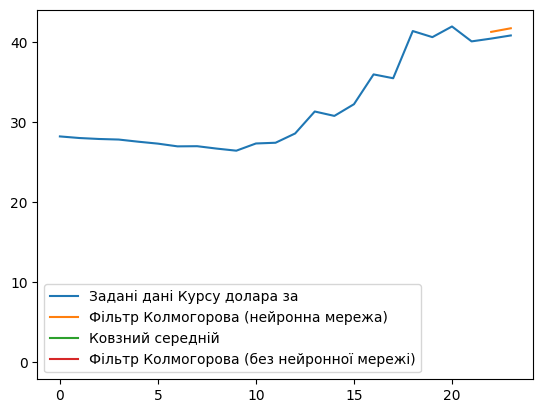

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import openpyxl

EPOCHS = 800
BATCH_SIZE = 32

def kolmogorov_filter(data: np.ndarray, num_predictions: int) -> list[float]:
    if len(data) < num_predictions:
        raise ValueError("Недостатньо даних для прогнозування вказаної кількості значень.")

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, input_shape=(1,), use_bias=False, kernel_initializer=tf.constant_initializer(0.5)),
        tf.keras.layers.Dense(1, use_bias=False, kernel_initializer=tf.constant_initializer(0.5)),
        tf.keras.layers.Lambda(lambda x: x * 0.95)
    ])
    
    model.compile(loss='mse', optimizer='adam')
    training_data = data[:-num_predictions].reshape(-1, 1)
    labels = data[num_predictions:].reshape(-1, 1)
    model.fit(training_data, labels, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    predictions = [data[-1]]
    for _ in range(num_predictions):
        pred = model.predict(np.array([predictions[-1]]))[0][0]
        predictions.append(pred)
    return predictions[1:]

def moving_average(data: np.ndarray, num_predictions: int) -> list[float]:
    predictions = [data[-1]]
    for i in range(num_predictions):
        pred = (data[-num_predictions + i] + data[-num_predictions + i + 1]) / 2
        predictions.append(pred)
    return predictions[1:]


def alternative_kolmogorov_filter(data: np.ndarray, num_predictions: int) -> list[float]:
    kf = data[-num_predictions-1:-1]
    if len(kf) == 0:
        kf = [data[-1]]
    elif len(kf) == 1:
        kf = [data[-2], data[-1]]
    for _ in range(1, num_predictions):
        kf = np.append(kf, 2*kf[-1] - kf[-2])
    return kf[-num_predictions:]


def read_data_from_excel(file_path):
    wb = openpyxl.load_workbook(file_path)
    sheet = wb.active
    data = []
    for row in sheet.iter_rows(values_only=True):
        data.extend(row)
    return data

def print_predictions_table(kf_predictions, ma_predictions, akf_predictions):
    table_kf = PrettyTable()
    table_kf.field_names = ["Прогноз №", "Значення"]
    for i, prediction in enumerate(kf_predictions):
        table_kf.add_row([i+1, prediction])
    print("Прогнози за допомогою фільтру Колмогорова використанням нейронної мережі:")
    print(table_kf)

    print()

    table_ma = PrettyTable()
    table_ma.field_names = ["Прогноз №", "Значення"]
    for i, prediction in enumerate(ma_predictions):
        table_ma.add_row([i+1, prediction])
    print("Прогнози за допомогою ковзного середнього:")
    print(table_ma)

    print()

    table_akf = PrettyTable()
    table_akf.field_names = ["Прогноз №", "Значення"]
    for i, prediction in enumerate(akf_predictions):
        table_akf.add_row([i+1, prediction])
    print("Прогнози за допомогою альтернативного фільтру Колмогорова (без нейронної мережі):")
    print(table_akf)

def plot_predictions(data, kf_predictions, ma_predictions, akf_predictions):
    plt.plot(data, label="Задані дані Курсу долара за ")
    plt.plot(range(len(data)-len(kf_predictions), len(data)), kf_predictions, label="Фільтр Колмогорова (нейронна мережа)")
    plt.plot(range(len(data)-len(ma_predictions), len(data)), ma_predictions, label="Ковзний середній")
    plt.plot(range(len(data)-len(akf_predictions), len(data)), akf_predictions, label="Фільтр Колмогорова (без нейронної мережі)")
    plt.legend()
    plt.show()

def main():
    print("Ласкаво просимо до програми для прогнозування курсу долара двома методами!\n1)Прогнозуючий фільтр Колмогорова\n2)Ковзний середній")

    while True:
        table = PrettyTable()
        table.field_names = ["Номер варіанту меню", "Оберіть дію:"]
        table.add_row(["1.", "Використовувати задані дані"])
        table.add_row(["2.", "Ввести свої дані"])
        table.add_row(["3.", "Загрузити дані з документа"])
        table.add_row(["0.", "Вийти з програми"])
        print(table)

        choice = input()

        if choice == "1":
            data = np.array([28.21, 28.01, 27.89, 27.82, 27.55, 27.31, 26.97, 26.99, 26.69, 26.43, 27.33, 27.42, 28.58, 31.32, 30.77, 32.23, 35.95, 35.47, 41.36, 40.60, 41.93, 40.07, 40.42, 40.81])
            break
        elif choice == "2":
            try:
                data_input = input("Введіть свої дані, розділені комами: ")
                data_input = data_input.split(",")
                data = np.array([float(i) for i in data_input])
            except ValueError:
                print("Помилка вводу. Будь ласка, спробуйте ще раз.")
                continue
            break
        elif choice == "3":
            try:
                file_path = input("Введіть шлях до файлу: ")
                data = read_data_from_excel(file_path)
            except Exception as e:
                print(f"Помилка при читанні даних: {e}")
                continue
            break       
        elif choice == "0":
            print("Завершення програми...")
            return
        else:
            print("Помилка вводу. Будь ласка, спробуйте ще раз.")

    while True:
        table = PrettyTable()
        table.field_names = ["Номер варіанту меню", "Метод прогнозування:"]
        table.add_row(["1.", "Прогнозуючий фільтр Колмогорова (з НМ)"])
        table.add_row(["2.", "Ковзний середній"])
        table.add_row(["3.", "Прогнозуючий фільтр Колмогорова (Звичайний)"])
        table.add_row(["4.", "Всі методи"])
        print(table)
        method_choice = input()
        if method_choice == "1":
            accuracy = float(input("Введіть бажану точність прогнозу в процентах (0-100): "))
            num_predictions_kf = int(input("Скільки значень ви хочете прогнозувати за допомогою фільтру Колмогорова? "))
            kf_predictions = kolmogorov_filter(data, num_predictions_kf)
            last_kf_prediction = kf_predictions[-1]
            i = num_predictions_kf
            while True:
                new_kf_prediction = kolmogorov_filter(data[:i], 1)[0]
                i += 1
                accuracy_kf = abs(last_kf_prediction - new_kf_prediction) / last_kf_prediction * 100
                if accuracy_kf <= accuracy:
                    kf_predictions.append(new_kf_prediction)
                    last_kf_prediction = new_kf_prediction
                else:
                    break
            akf_predictions = [0]
            ma_predictions = [0]
            print_predictions_table(kf_predictions, ma_predictions, akf_predictions)
            plot_predictions(data, kf_predictions, ma_predictions, akf_predictions)
            break
        elif method_choice == "2":
            accuracy = float(input("Введіть бажану точність прогнозу в процентах (0-100): "))
            num_predictions_ma = int(input("Скільки значень ви хочете прогнозувати за допомогою ковзного середнього? "))
            ma_predictions = moving_average(data, num_predictions_ma)
            akf_predictions = [0]
            kf_predictions = [0]
            print_predictions_table(kf_predictions, ma_predictions, akf_predictions)
            plot_predictions(data, kf_predictions, ma_predictions, akf_predictions)
            break
        elif method_choice == "3":
            accuracy = float(input("Введіть бажану точність прогнозу в процентах (0-100): "))
            num_predictions_akf = int(input("Скільки значень ви хочете прогнозувати за допомогою фільтру Колмогорова без нейромереж? "))
            akf_predictions = alternative_kolmogorov_filter(data, num_predictions_akf)
            last_akf_prediction = akf_predictions[-1]
            i = num_predictions_akf
            while True:
                new_akf_prediction = alternative_kolmogorov_filter(data[:i], 1)[0]
                i += 1
                accuracy_akf = abs(last_akf_prediction - new_akf_prediction) / last_akf_prediction * 100
                if accuracy_akf <= accuracy:
                    akf_predictions.append(new_akf_prediction)
                    last_akf_prediction = new_akf_prediction
                else:
                    break
            kf_predictions = [0]
            ma_predictions = [0]
            print_predictions_table(kf_predictions, ma_predictions, akf_predictions)
            plot_predictions(data, kf_predictions, ma_predictions, akf_predictions)
            break
        elif method_choice == "4":
            accuracy = float(input("Введіть бажану точність прогнозу в процентах (0-100): "))
            num_predictions_kf = int(input("Скільки значень ви хочете прогнозувати за допомогою фільтру Колмогорова? "))
            num_predictions_ma = int(input("Скільки значень ви хочете прогнозувати за допомогою ковзного середнього? "))
            num_predictions_akf = int(input("Скільки значень ви хочете прогнозувати за допомогою фільтру Колмогорова без нейромереж? "))
            kf_predictions = kolmogorov_filter(data, num_predictions_kf)
            last_kf_prediction = kf_predictions[-1]
            i = num_predictions_kf
            while True:
                new_kf_prediction = kolmogorov_filter(data[:i], 1)[0]
                i += 1
                accuracy_kf = abs(last_kf_prediction - new_kf_prediction) / last_kf_prediction * 100
                if accuracy_kf <= accuracy:
                    kf_predictions.append(new_kf_prediction)
                    last_kf_prediction = new_kf_prediction
                else:
                    break
            akf_predictions = alternative_kolmogorov_filter(data, num_predictions_akf)
            last_akf_prediction = akf_predictions[-1]
            i = num_predictions_akf
            while True:
                new_akf_prediction = alternative_kolmogorov_filter(data[:i], 1)[0]
                i += 1
                accuracy_akf = abs(last_akf_prediction - new_akf_prediction) / last_akf_prediction * 100
                if accuracy_akf <= accuracy:
                    akf_predictions.append(new_akf_prediction)
                    last_akf_prediction = new_akf_prediction
                else:
                    break
            ma_predictions = moving_average(data, num_predictions_ma)
            print_predictions_table(kf_predictions, ma_predictions, akf_predictions)
            plot_predictions(data, kf_predictions, ma_predictions, akf_predictions)
            break
        else:
            print("Помилка вводу. Будь ласка, спробуйте ще раз.")
            continue

if __name__ == '__main__':
    main()
